In [1]:
!wget https://download.europe.naverlabs.com//virtual_kitti_2.0.3/vkitti_2.0.3_rgb.tar
!mkdir -p vkitti_rgb
!tar -xf /content/vkitti_2.0.3_rgb.tar -C vkitti_rgb


--2025-11-14 06:03:44--  https://download.europe.naverlabs.com//virtual_kitti_2.0.3/vkitti_2.0.3_rgb.tar
Resolving download.europe.naverlabs.com (download.europe.naverlabs.com)... 110.234.56.25
Connecting to download.europe.naverlabs.com (download.europe.naverlabs.com)|110.234.56.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7532472320 (7.0G) [application/x-tar]
Saving to: ‘vkitti_2.0.3_rgb.tar’

vkitti_2.0.3_rgb.ta 100%[===================>]   7.01G  23.8MB/s    in 5m 32s  

2025-11-14 06:09:17 (21.7 MB/s) - ‘vkitti_2.0.3_rgb.tar’ saved [7532472320/7532472320]



In [2]:
!wget https://download.europe.naverlabs.com//virtual_kitti_2.0.3/vkitti_2.0.3_classSegmentation.tar
!mkdir -p vkitti_gt
!tar -xf /content/vkitti_2.0.3_classSegmentation.tar -C vkitti_gt


--2025-11-14 06:17:51--  https://download.europe.naverlabs.com//virtual_kitti_2.0.3/vkitti_2.0.3_classSegmentation.tar
Resolving download.europe.naverlabs.com (download.europe.naverlabs.com)... 110.234.56.25
Connecting to download.europe.naverlabs.com (download.europe.naverlabs.com)|110.234.56.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1015961600 (969M) [application/x-tar]
Saving to: ‘vkitti_2.0.3_classSegmentation.tar’

vkitti_2.0.3_classS 100%[===================>] 968.90M  25.9MB/s    in 39s     

2025-11-14 06:18:31 (24.6 MB/s) - ‘vkitti_2.0.3_classSegmentation.tar’ saved [1015961600/1015961600]



In [3]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
!mkdir /content/kitti
! unzip /content/data_semantics.zip -d kitti

--2025-11-14 06:21:11--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.6, 16.12.32.5, 52.219.168.84, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  22.1MB/s    in 15s     

2025-11-14 06:21:27 (20.3 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]

Archive:  /content/data_semantics.zip
   creating: kitti/testing/
   creating: kitti/testing/image_2/
  inflating: kitti/testing/image_2/000000_10.png  
  inflating: kitti/testing/image_2/000001_10.png  
  inflating: kitti/testing/image_2/000002_10.png  
  inflating: kitti/testing/image_2/000003_10.png  
  inflating: kitti/testing/image_2/000004_10.png  
  inflating: kitti/testing/image_2/000005

Dataset

In [2]:
import os
import glob
import numpy as np
from PIL import Image
# --- FINAL CLASSES ---
final_classes = {
    'Sky': 0,
    'Building': 1,
    'Vehicle': 2,
    'Vegetation': 3,
    'Sign/Pole': 4,
    'Ground': 5,
    'Other': 6
}

# --- VKITTI RGB → FINAL ---
vkitti_rgb2final = {
    (210, 0, 200): 'Ground',       # Terrain
    (90, 200, 255): 'Sky',         # Sky
    (0, 199, 0): 'Vegetation',     # Tree
    (90, 240, 0): 'Vegetation',    # Vegetation
    (140, 140, 140): 'Building',   # Building
    (100, 60, 100): 'Ground',      # Road
    (250, 100, 255): 'Sign/Pole',  # GuardRail
    (255, 255, 0): 'Sign/Pole',    # TrafficSign
    (200, 200, 0): 'Sign/Pole',    # TrafficLight
    (255, 130, 0): 'Sign/Pole',    # Pole
    (80, 80, 80): 'Other',         # Misc
    (160, 60, 60): 'Vehicle',      # Truck
    (255, 127, 80): 'Vehicle',     # Car
    (0, 139, 139): 'Vehicle',      # Van
    (0, 0, 0): 'Other'             # Undefined
}

# --- KITTI RGB → FINAL ---
kitti_rgb2final = {
    (128, 64, 128): 'Ground',     # road
    (244, 35, 232): 'Ground',     # sidewalk
    (70, 70, 70): 'Building',     # building
    (102, 102, 156): 'Building',  # wall
    (190, 153, 153): 'Building',  # fence
    (153, 153, 153): 'Sign/Pole', # pole
    (250, 170, 30): 'Sign/Pole',  # traffic light
    (220, 220, 0): 'Sign/Pole',   # traffic sign
    (107, 142, 35): 'Vegetation', # vegetation
    (152, 251, 152): 'Vegetation',# terrain
    (70, 130, 180): 'Sky',        # sky
    (0, 0, 142): 'Vehicle',       # car
    (0, 0, 70): 'Vehicle',        # truck
    (0, 60, 100): 'Vehicle',      # bus
    (0, 80, 100): 'Vehicle',      # train
    (119, 11, 32): 'Vehicle',     # bicycle
    (81, 0, 81): 'Ground',        # ground
    (0, 0, 0): 'Other'            # unlabeled
}

# --- CLASS ID → RGB (for visualization) ---
final_classes_colors = {
    0: (90, 200, 255),   # Sky
    1: (140, 140, 140),  # Building
    2: (255, 127, 80),   # Vehicle
    3: (90, 240, 0),     # Vegetation
    4: (255, 255, 0),    # Sign/Pole
    5: (210, 0, 200),    # Ground
    6: (80, 80, 80)      # Other
}

def rgb_mask_to_class(mask_img, rgb_mapping, final_classes):
    mask = np.array(mask_img)
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for rgb, cname in rgb_mapping.items():
        class_id = final_classes[cname]
        matches = np.all(mask == rgb, axis=-1)
        class_mask[matches] = class_id
    return class_mask

def class_to_rgb(mask_np, class_to_color):
    """Convert integer class mask back to RGB for visualization."""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in class_to_color.items():
        rgb[mask_np == class_id] = color
    return rgb

In [29]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import glob, os
import albumentations as A

# from data_helper import final_classes, vkitti_rgb2final, kitti_rgb2final, rgb_mask_to_class

class SegDataset(Dataset):
    def __init__(self, image_dirs, mask_dirs, dataset_type='vkitti', aug_case=None, size=(512, 256)):
        """
        image_dirs: str or list of str paths to image folders
        mask_dirs: str or list of str paths to mask folders
        """
        if isinstance(image_dirs, str):
            image_dirs = [image_dirs]
        if isinstance(mask_dirs, str):
            mask_dirs = [mask_dirs]

        self.image_paths = []
        self.mask_paths = []

        for img_dir, msk_dir in zip(image_dirs, mask_dirs):
            img_files = sorted([p for ext in ('*.jpg', '*.png') for p in glob.glob(os.path.join(img_dir, ext))])
            msk_files = sorted([p for ext in ('*.jpg', '*.png') for p in glob.glob(os.path.join(msk_dir, ext))])
            self.image_paths.extend(img_files)
            self.mask_paths.extend(msk_files)

        if len(self.image_paths) != len(self.mask_paths):
            raise ValueError("Number of images and masks must match across all folders.")

        self.size = size
        self.aug_case = aug_case
        self.transform = self.get_augmentations(aug_case)
        self.dataset_type = dataset_type.lower()

        if self.dataset_type == 'vkitti':
            self.rgb_mapping = vkitti_rgb2final
        elif self.dataset_type == 'kitti':
            self.rgb_mapping = kitti_rgb2final
        else:
            raise ValueError("dataset_type must be 'vkitti' or 'kitti'")

    def __len__(self):
        return len(self.image_paths)

    def get_augmentations(self, case):
        """Photometric augmentations applied only to images."""
        if case is None:
            return A.Resize(*self.size)
        if case == 'CJ':
            return A.Compose([
                A.Resize(*self.size),
                A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
            ])
        elif case == 'RGBS':
            return A.Compose([
                A.Resize(*self.size),
                A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
            ])
        elif case == 'BLUR':
            return A.Compose([
                A.GaussianBlur(blur_limit=(3,7), p=0.5),
            ])
        elif case == 'EQUAL':
            return A.Compose([
                A.Resize(*self.size),
                A.OneOf([
                    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=1.0),
                    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1.0),
                    A.GaussianBlur(blur_limit=(3,7), p=1.0),
                ], p=1.0),
            ])
        else:
            raise ValueError("Invalid augmentation case. Choose from 'CJ','RGBS','BLUR','EQUAL'")

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = np.array(Image.open(img_path).convert("RGB"))
        mask = Image.open(mask_path).convert("RGB")
        mask = mask.resize((self.size), Image.NEAREST)
        mask_np = np.array(mask)
        mask_np = rgb_mask_to_class(mask_np, self.rgb_mapping, final_classes)

        if self.transform:
            img_aug = self.transform(image=img)['image']
        else:
            img_aug = img

        img_t = torch.from_numpy(img_aug.transpose(2, 1, 0)).float() / 255.0
        mask_t = torch.from_numpy(mask_np).long()

        return img_t, mask_t


In [35]:
import matplotlib.pyplot as plt
image_dirs = [
    "/content/vkitti_rgb/Scene01/clone/frames/rgb/Camera_0",
    "/content/vkitti_rgb/Scene02/clone/frames/rgb/Camera_0",
    "/content/vkitti_rgb/Scene06/clone/frames/rgb/Camera_0",
    "/content/vkitti_rgb/Scene18/clone/frames/rgb/Camera_0",
    "/content/vkitti_rgb/Scene20/clone/frames/rgb/Camera_0",
]

mask_dirs = [
    "/content/vkitti_gt/Scene01/clone/frames/classSegmentation/Camera_0/",
    "/content/vkitti_gt/Scene02/clone/frames/classSegmentation/Camera_0/",
    "/content/vkitti_gt/Scene06/clone/frames/classSegmentation/Camera_0/",
    "/content/vkitti_gt/Scene18/clone/frames/classSegmentation/Camera_0/",
    "/content/vkitti_gt/Scene20/clone/frames/classSegmentation/Camera_0/",
]
train_set = SegDataset(image_dirs=image_dirs,mask_dirs=mask_dirs, dataset_type='vkitti',aug_case=None)
train_loader = DataLoader(
    train_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)

In [36]:
val_test_set = SegDataset("/content/kitti/training/image_2", "/content/kitti/training/semantic_rgb/", dataset_type='kitti',aug_case=None)
size = int(0.5 * len(val_test_set))
generator = torch.Generator().manual_seed(42)
val_set, test_set = random_split(val_test_set, [size,size], generator=generator)
val_loader = DataLoader(
    val_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)
test_loader = DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)

Baselines

In [37]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class SimpleSegNet(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super(SimpleSegNet, self).__init__()

        resnet = models.resnet18(pretrained=pretrained)
        self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder1 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4


        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        self.out_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e0 = self.encoder0(x)
        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.up4(e4) + e3
        d3 = self.up3(d4) + e2
        d2 = self.up2(d3) + e1
        d1 = self.up1(d2) + e0

        out = self.out_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out
Segnet=SimpleSegNet()

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        targets_onehot = torch.nn.functional.one_hot(targets, preds.shape[1]).permute(0,3,1,2).float()
        intersection = (preds * targets_onehot).sum(dim=(2,3))
        union = preds.sum(dim=(2,3)) + targets_onehot.sum(dim=(2,3))
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

num_classes = 7

def train_model(model, train_loader, val_loader, num_epochs=15, lr=1e-3, device='cuda'):
    model = model.to(device)
    ce_loss = nn.CrossEntropyLoss()
    dice_loss = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_iou = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = ce_loss(outputs, masks) + 0.5 * dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        iou_per_class = torch.zeros(num_classes, device=device)
        eps = 1e-6

        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = ce_loss(outputs, masks)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)

                for cls in range(1, num_classes):  # skip background = 0
                    pred_cls = preds == cls
                    mask_cls = masks == cls
                    intersection = torch.logical_and(pred_cls, mask_cls).sum().float()
                    union = torch.logical_or(pred_cls, mask_cls).sum().float()
                    iou_per_class[cls] += intersection / (union + eps)

        val_loss /= len(val_loader)
        mean_iou = (iou_per_class[1:] / len(val_loader)).mean().item()

        print(f"Epoch {epoch+1:02d}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val mIoU={mean_iou:.4f}")




    print("Training complete.")



In [ ]:
train_model(Segnet, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda')

Epoch 1/10 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Epoch 01: Train Loss=1.4665 | Val Loss=1.4947 | Val mIoU=0.1462


Epoch 2/10 [Train]:  36%|███▌      | 24/67 [00:49<01:01,  1.44s/it]

In [18]:
import torch
from tqdm import tqdm

def evaluate_segmentation(model, dataloader, num_classes=7, device='cuda', eps=1e-6):
    """
    Evaluate a segmentation model on a given dataloader.

    Args:
        model: PyTorch segmentation model
        dataloader: DataLoader providing (images, masks)
        num_classes: number of segmentation classes
        device: 'cuda' or 'cpu'
        eps: small epsilon to avoid division by zero

    Returns:
        iou_per_class: Tensor of IoU per class
        mean_iou: Mean IoU across classes
    """
    model.to(device)
    model.eval()
    iou_per_class = torch.zeros(num_classes, device=device)

    with torch.no_grad():
        for imgs, masks in tqdm(dataloader):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            for cls in range(num_classes):
                pred_cls = preds == cls
                mask_cls = masks == cls

                intersection = torch.logical_and(pred_cls, mask_cls).sum().float()
                union = torch.logical_or(pred_cls, mask_cls).sum().float()
                iou_per_class[cls] += intersection / (union + eps)

    # Average IoU per class
    iou_per_class /= len(dataloader)
    mean_iou = iou_per_class.mean().item()

    return iou_per_class, mean_iou


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]

Mean IoU: 0.1970


# Color jitter

In [ ]:
cj_set = SegDataset(image_dirs=image_dirs,mask_dirs=mask_dirs, dataset_type='vkitti',aug_case='CJ')
cj_loader = DataLoader(
    cj_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)
train_model(Segnet,cj_loader, val_loader, num_epochs=15, lr=1e-3, device='cuda')

Epoch 1/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Epoch 01: Train Loss=0.7706 | Val Loss=2.0566 | Val mIoU=0.1914


Epoch 2/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch 02: Train Loss=0.7535 | Val Loss=1.2413 | Val mIoU=0.2618


Epoch 3/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch 03: Train Loss=0.6470 | Val Loss=1.6281 | Val mIoU=0.2085


Epoch 4/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 04: Train Loss=0.5572 | Val Loss=1.8838 | Val mIoU=0.2238


Epoch 5/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Epoch 05: Train Loss=0.4905 | Val Loss=1.4651 | Val mIoU=0.2653


Epoch 6/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 06: Train Loss=0.4583 | Val Loss=1.6325 | Val mIoU=0.2606


Epoch 7/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 07: Train Loss=0.4507 | Val Loss=1.6913 | Val mIoU=0.2787


Epoch 8/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


Epoch 08: Train Loss=0.4407 | Val Loss=3.4016 | Val mIoU=0.1682


Epoch 9/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Epoch 09: Train Loss=0.4601 | Val Loss=1.0206 | Val mIoU=0.3499


Epoch 10/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 10: Train Loss=0.4276 | Val Loss=1.2960 | Val mIoU=0.2954


Epoch 11/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Epoch 11: Train Loss=0.4280 | Val Loss=1.7676 | Val mIoU=0.2552


Epoch 12/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch 12: Train Loss=0.3741 | Val Loss=2.2444 | Val mIoU=0.2170


Epoch 13/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 13: Train Loss=0.3813 | Val Loss=1.3873 | Val mIoU=0.3068


Epoch 14/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 14: Train Loss=0.3707 | Val Loss=2.4493 | Val mIoU=0.2216


Epoch 15/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

Epoch 15: Train Loss=0.3651 | Val Loss=2.2751 | Val mIoU=0.2722
Training complete.


In [ ]:
import torch
from tqdm import tqdm
device='cuda'
num_classes = len(final_classes)
iou_per_class = torch.zeros(num_classes, device=device)
eps = 1e-6
model=Segnet
model.eval()
with torch.no_grad():
    for imgs, masks in tqdm(test_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        for cls in range(num_classes):
            pred_cls = preds == cls
            mask_cls = masks == cls

            intersection = torch.logical_and(pred_cls, mask_cls).sum().float()
            union = torch.logical_or(pred_cls, mask_cls).sum().float()
            iou_per_class[cls] += intersection / (union + eps)

# Average IoU per class
mean_iou = (iou_per_class / len(test_loader)).mean().item()
print(f"Mean IoU: {mean_iou:.4f}")


100%|██████████| 4/4 [00:08<00:00,  2.04s/it]

Mean IoU: 0.2931


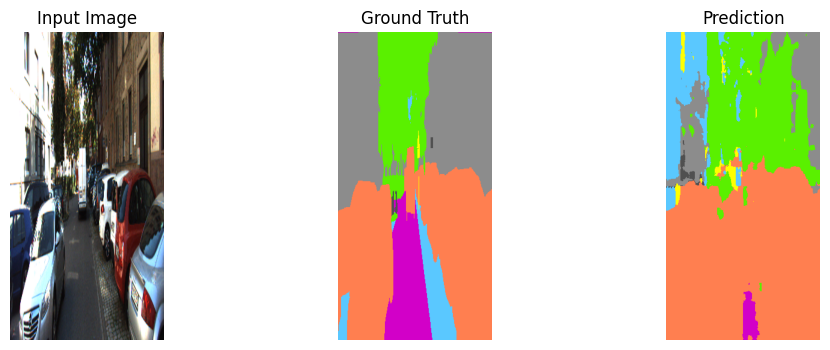

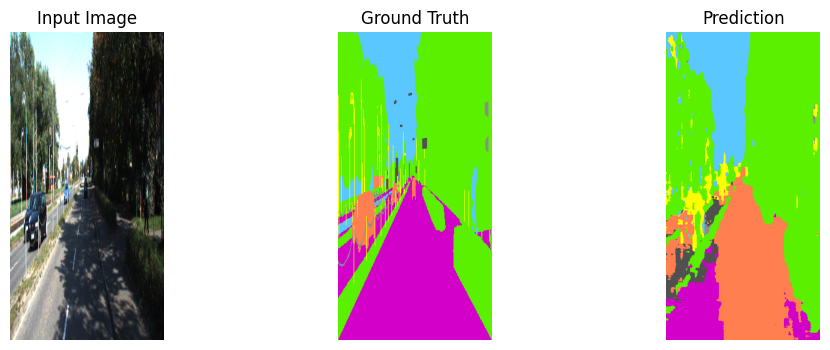

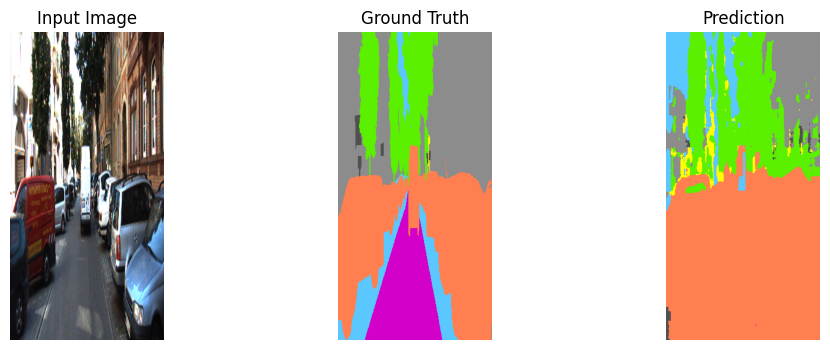

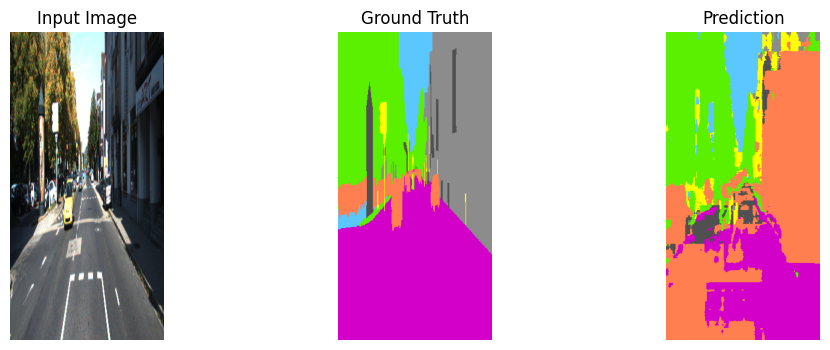

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Make sure the model is in eval mode
model.eval()
device = 'cuda'

# Take a batch from test_loader
imgs, masks = next(iter(test_loader))
imgs, masks = imgs.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(imgs)
    preds = torch.argmax(outputs, dim=1)

# Move tensors to CPU for visualization
imgs = imgs.cpu().numpy()
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

# Number of examples to visualize
num_examples = min(4, imgs.shape[0])

for i in range(num_examples):
    img = imgs[i].transpose(1,2,0)  # C,H,W → H,W,C
    mask_rgb = class_to_rgb(masks[i], final_classes_colors)
    pred_rgb = class_to_rgb(preds[i], final_classes_colors)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask_rgb)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred_rgb)
    plt.title("Prediction")
    plt.axis('off')

    plt.show()


# RGBS

In [ ]:
rgbs_set = SegDataset("/content/vkitti_rgb/Scene01/clone/frames/rgb/Camera_0", "/content/vkitti_gt/Scene01/clone/frames/classSegmentation/Camera_0/", dataset_type='vkitti',aug_case='RGBS')
rgbs_loader = DataLoader(
    rgbs_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)
train_model(Segnet,cj_loader, val_loader, num_epochs=15, lr=1e-3, device='cuda')

Epoch 1/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch 01: Train Loss=0.3596 | Val Loss=1.7994 | Val mIoU=0.2663


Epoch 2/15 [Val]: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 02: Train Loss=0.3839 | Val Loss=1.9285 | Val mIoU=0.2516


Epoch 3/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Epoch 03: Train Loss=0.4005 | Val Loss=2.5079 | Val mIoU=0.2029


Epoch 4/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Epoch 04: Train Loss=0.3572 | Val Loss=1.5909 | Val mIoU=0.2675


Epoch 5/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 05: Train Loss=0.3212 | Val Loss=1.2087 | Val mIoU=0.3256


Epoch 6/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 06: Train Loss=0.3191 | Val Loss=1.3499 | Val mIoU=0.3129


Epoch 7/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 07: Train Loss=0.3158 | Val Loss=2.0758 | Val mIoU=0.2941


Epoch 8/15 [Val]: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Epoch 08: Train Loss=0.3515 | Val Loss=0.9425 | Val mIoU=0.3881


Epoch 9/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch 09: Train Loss=0.3247 | Val Loss=1.8849 | Val mIoU=0.2413


Epoch 10/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Epoch 10: Train Loss=0.3146 | Val Loss=2.2393 | Val mIoU=0.2577


Epoch 11/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 11: Train Loss=0.3252 | Val Loss=1.8425 | Val mIoU=0.2698


Epoch 12/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch 12: Train Loss=0.3186 | Val Loss=1.4728 | Val mIoU=0.3346


Epoch 13/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 13: Train Loss=0.3139 | Val Loss=1.1372 | Val mIoU=0.3516


Epoch 14/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Epoch 14: Train Loss=0.2746 | Val Loss=1.9824 | Val mIoU=0.2599


Epoch 15/15 [Val]: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]

Epoch 15: Train Loss=0.2620 | Val Loss=1.3038 | Val mIoU=0.3350
Training complete.


In [ ]:
import torch
from tqdm import tqdm
device='cuda'
num_classes = len(final_classes)  # or however many classes you have
iou_per_class = torch.zeros(num_classes, device=device)
eps = 1e-6
model=Segnet
model.eval()
with torch.no_grad():
    for imgs, masks in tqdm(test_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        for cls in range(num_classes):
            pred_cls = preds == cls
            mask_cls = masks == cls

            intersection = torch.logical_and(pred_cls, mask_cls).sum().float()
            union = torch.logical_or(pred_cls, mask_cls).sum().float()
            iou_per_class[cls] += intersection / (union + eps)

# Average IoU per class
mean_iou = (iou_per_class / len(test_loader)).mean().item()
print(f"Mean IoU: {mean_iou:.4f}")


100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

Mean IoU: 0.3420


BLUR

In [ ]:
blur_set = SegDataset("/content/vkitti_rgb/Scene01/clone/frames/rgb/Camera_0", "/content/vkitti_gt/Scene01/clone/frames/classSegmentation/Camera_0/", dataset_type='vkitti',aug_case='BLUR')
blur_loader = DataLoader(
    blur_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)
train_model(Segnet,blur_loader, val_loader, num_epochs=15, lr=1e-3, device='cuda')

Epoch 1/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 01: Train Loss=0.2599 | Val Loss=2.2739 | Val mIoU=0.2596


Epoch 2/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Epoch 02: Train Loss=0.3233 | Val Loss=1.4763 | Val mIoU=0.3142


Epoch 3/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 03: Train Loss=0.3155 | Val Loss=1.9674 | Val mIoU=0.2032


Epoch 4/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 04: Train Loss=0.3207 | Val Loss=2.0459 | Val mIoU=0.2302


Epoch 5/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 05: Train Loss=0.3066 | Val Loss=2.0098 | Val mIoU=0.1957


Epoch 6/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Epoch 06: Train Loss=0.3016 | Val Loss=1.7288 | Val mIoU=0.2880


Epoch 7/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 07: Train Loss=0.2671 | Val Loss=2.0082 | Val mIoU=0.2292


Epoch 8/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch 08: Train Loss=0.2699 | Val Loss=1.8568 | Val mIoU=0.2800


Epoch 9/15 [Val]: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 09: Train Loss=0.2645 | Val Loss=1.4358 | Val mIoU=0.2749


Epoch 10/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch 10: Train Loss=0.2457 | Val Loss=1.0376 | Val mIoU=0.3638


Epoch 11/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 11: Train Loss=0.2452 | Val Loss=2.2004 | Val mIoU=0.2513


Epoch 12/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 12: Train Loss=0.2391 | Val Loss=2.7066 | Val mIoU=0.2196


Epoch 13/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 13: Train Loss=0.2311 | Val Loss=1.6698 | Val mIoU=0.2572


Epoch 14/15 [Val]: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 14: Train Loss=0.2272 | Val Loss=1.6263 | Val mIoU=0.2832


Epoch 15/15 [Val]: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

Epoch 15: Train Loss=0.2295 | Val Loss=1.5265 | Val mIoU=0.3415
Training complete.


In [ ]:
import torch
from tqdm import tqdm
device='cuda'
num_classes = len(final_classes)  # or however many classes you have
iou_per_class = torch.zeros(num_classes, device=device)
eps = 1e-6
model=Segnet
model.eval()
with torch.no_grad():
    for imgs, masks in tqdm(test_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        for cls in range(num_classes):
            pred_cls = preds == cls
            mask_cls = masks == cls

            intersection = torch.logical_and(pred_cls, mask_cls).sum().float()
            union = torch.logical_or(pred_cls, mask_cls).sum().float()
            iou_per_class[cls] += intersection / (union + eps)

# Average IoU per class
mean_iou = (iou_per_class / len(test_loader)).mean().item()
print(f"Mean IoU: {mean_iou:.4f}")


100%|██████████| 4/4 [00:08<00:00,  2.02s/it]

Mean IoU: 0.3128


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Make sure the model is in eval mode
model.eval()
device = 'cuda'

# Take a batch from test_loader
imgs, masks = next(iter(test_loader))
imgs, masks = imgs.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(imgs)
    preds = torch.argmax(outputs, dim=1)

# Move tensors to CPU for visualization
imgs = imgs.cpu().numpy()
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

# Number of examples to visualize
num_examples = min(4, imgs.shape[0])

for i in range(num_examples):
    img = imgs[i].transpose(1,2,0)  # C,H,W → H,W,C
    mask_rgb = class_to_rgb(masks[i], final_classes_colors)
    pred_rgb = class_to_rgb(preds[i], final_classes_colors)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask_rgb)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred_rgb)
    plt.title("Prediction")
    plt.axis('off')

    plt.show()


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 1242] at entry 0 and [3, 376, 1241] at entry 5
